In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from pathlib import Path

import matplotlib.pyplot as plt
import motorlab as ml
import numpy as np
import scipy
import yaml

from sklearn.decomposition import PCA

In [3]:
os.chdir(Path().resolve().parent)

### old vs new comparison

i'm comparing the old data that works well with the new data that doesn't work.

##### center of mass

i'm plotting the center of mass during trials of both datasets and they look exactly the same with the exception that the standardization changed from one dataset to another (axis differ).

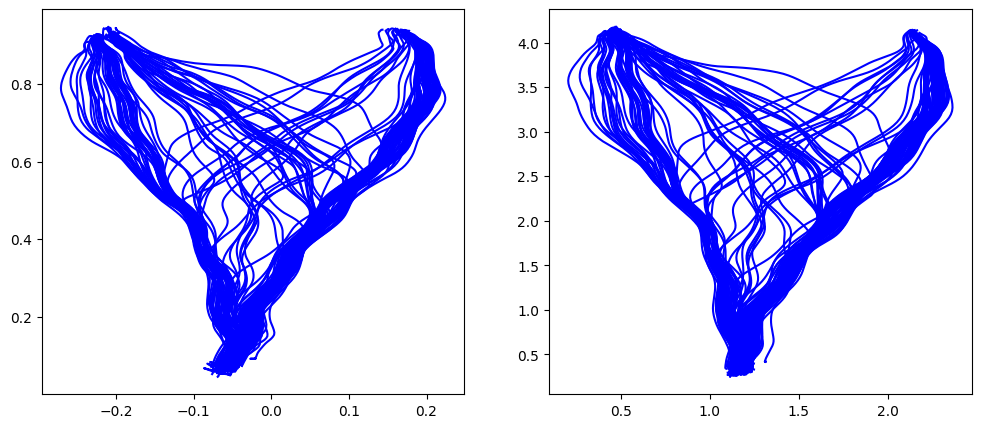

In [4]:
NEW_SPIKE_COUNT_DIR = Path("data/gbyk/ken_20230614/poses/")
old_poses = ml.data.load_from_memmap(NEW_SPIKE_COUNT_DIR)

NEW_POSES_DIR = Path("data/gbyk/ken_20230614_spikes_sorted_SES/poses/")
new_poses = ml.data.load_from_memmap(NEW_POSES_DIR)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
TRIALS_DIR = Path("data/gbyk/ken_20230614_spikes_sorted_SES/trials/")
for trial in sorted(TRIALS_DIR.iterdir()):
    with trial.open("rb") as f:
        trial_info = yaml.safe_load(f)
        start = int(trial_info["first_frame_idx"] / 50)
        end = start + int(trial_info["num_frames"] / 50)
        old_poses = old_poses.reshape(-1, 21, 3)
        com_keypoints = ml.poses.com_keypoints["gbyk"]
        com = old_poses[:, com_keypoints, :2].mean(axis=1)
        axs[0].plot(-com[start:end, 0], com[start:end, 1], color="b")
        new_poses = new_poses.reshape(-1, 21, 3)
        com_keypoints = ml.poses.com_keypoints["gbyk"]
        com = new_poses[:, com_keypoints, :2].mean(axis=1)
        axs[1].plot(com[start:end, 0], com[start:end, 1], color="b")

##### firing rate

i also have a plot in which the x-axis represents neurons and y-axis represents the firing rate of that neuron (spike count over the entire session divided by the length of the session). i don't see alarmingly difference.

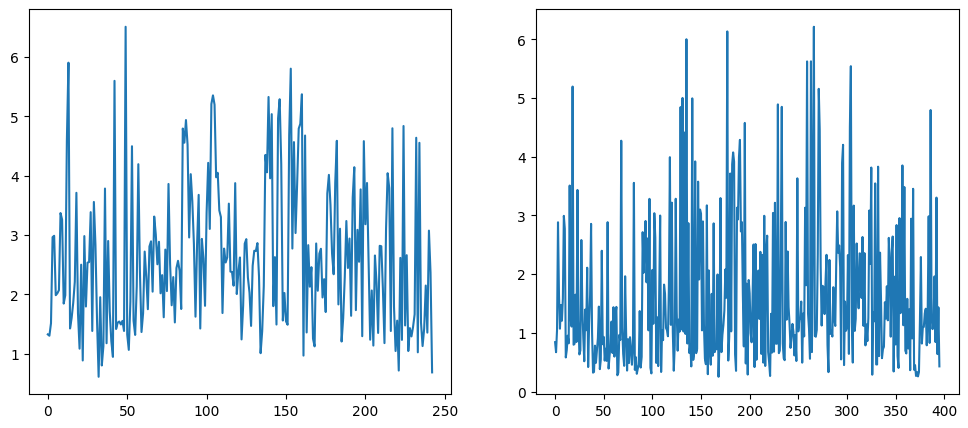

In [11]:
NEW_SPIKE_COUNT_DIR = Path("data/gbyk/ken_20230614/spike_count/")
old_spike_count = ml.data.load_from_memmap(NEW_SPIKE_COUNT_DIR)
old_spike_rate = old_spike_count.sum(axis=0) / old_spike_count.shape[0]

NEW_SPIKE_COUNT_DIR = Path(
    "data/gbyk/ken_20230614_spikes_sorted_SES/spike_count/"
)
new_spike_count = ml.data.load_from_memmap(NEW_SPIKE_COUNT_DIR)
new_spike_rate = new_spike_count.mean(axis=0)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(old_spike_rate)
axs[1].plot(new_spike_rate)
plt.show()

### comparing firing rates

i'm plotting a histogram of firing rates (counted over neurons) for each new session. we can see a difference between bexter and keno, but within each monkey the plots look the same. i'm also printing some statistics such as the mean of the dataset, the number of neurons and the fraction of zeros in the spike count matrix and, again, within each monkey these statistics look the same.

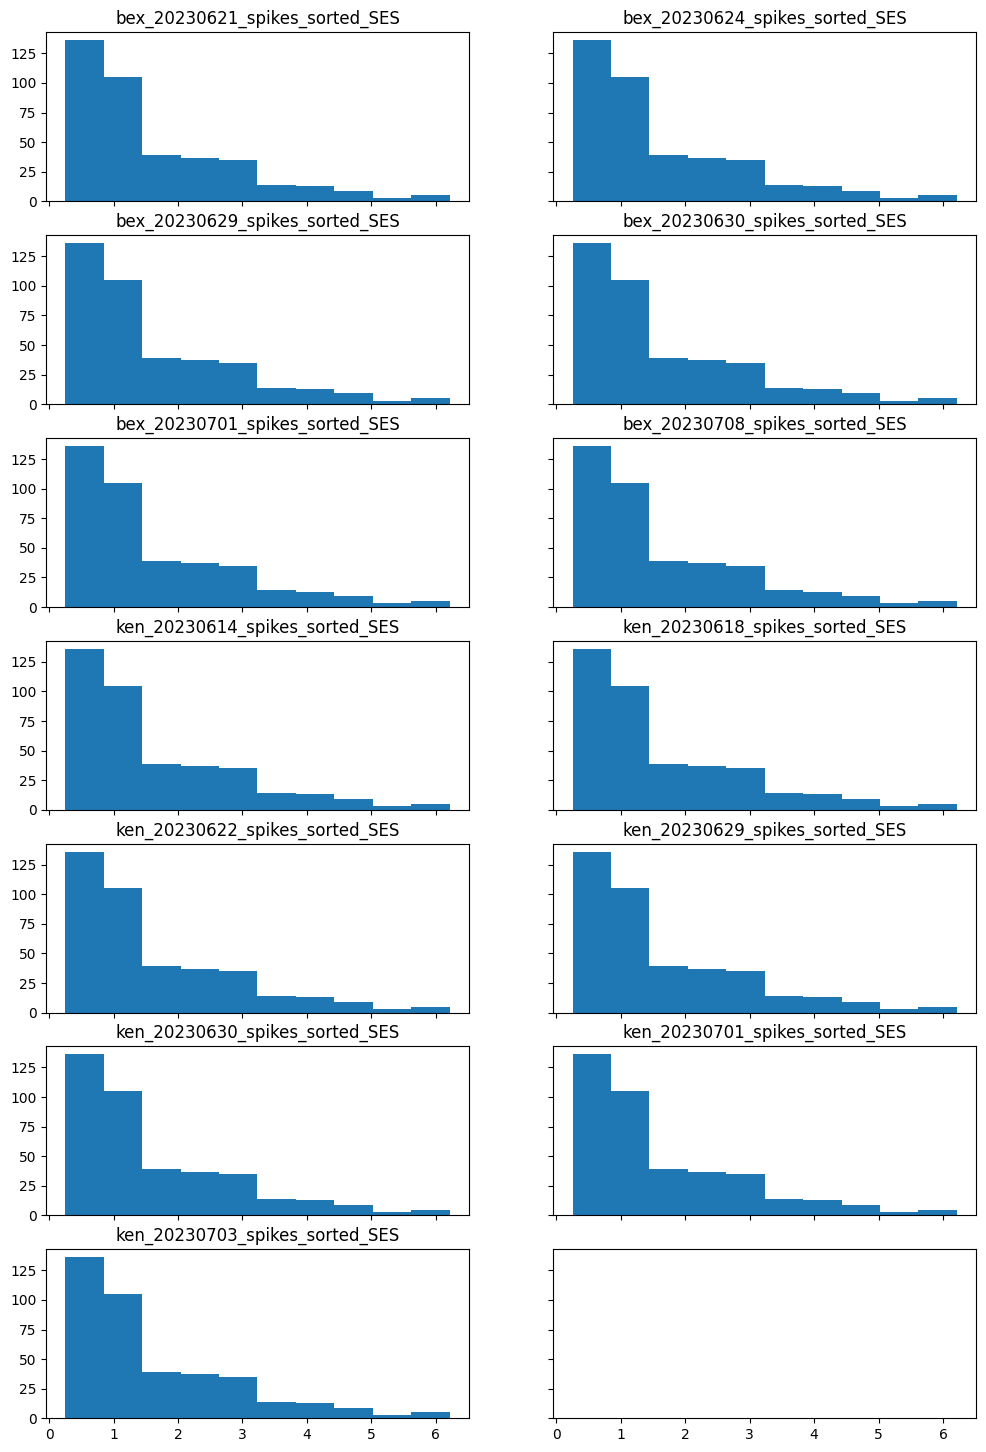

In [18]:
sessions = [
    "bex_20230621_spikes_sorted_SES",  # before
    "bex_20230624_spikes_sorted_SES",  # before
    "bex_20230629_spikes_sorted_SES",  # before
    "bex_20230630_spikes_sorted_SES",  # before
    "bex_20230701_spikes_sorted_SES",  # before
    "bex_20230708_spikes_sorted_SES",  # while
    "ken_20230614_spikes_sorted_SES",  # while and before
    "ken_20230618_spikes_sorted_SES",  # before
    "ken_20230622_spikes_sorted_SES",  # while, before and free
    "ken_20230629_spikes_sorted_SES",  # while, before and free
    "ken_20230630_spikes_sorted_SES",  # while
    "ken_20230701_spikes_sorted_SES",  # before
    "ken_20230703_spikes_sorted_SES",  # while
]
fig, axs = plt.subplots(
    len(sessions) // 2 + 1, 2, figsize=(12, 18), sharex=True, sharey=True
)

for i, session in enumerate(sessions):
    SPIKE_COUNT_DIR = Path(f"data/gbyk/{session}/spike_count/")
    spike_count = ml.data.load_from_memmap(SPIKE_COUNT_DIR)
    spike_rate = spike_count.mean(axis=0)
    axs[i // 2, i % 2].set_title(session)
    axs[i // 2, i % 2].hist(new_spike_rate)

### pcs

plot the principal component over the first 5 trials for 3 different sessions of keno.

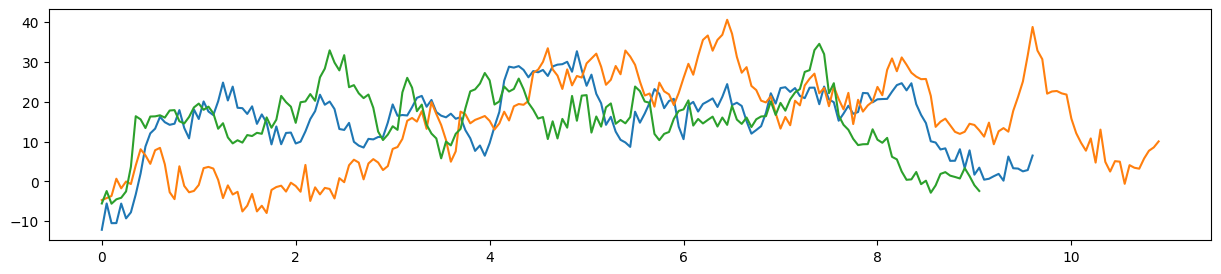

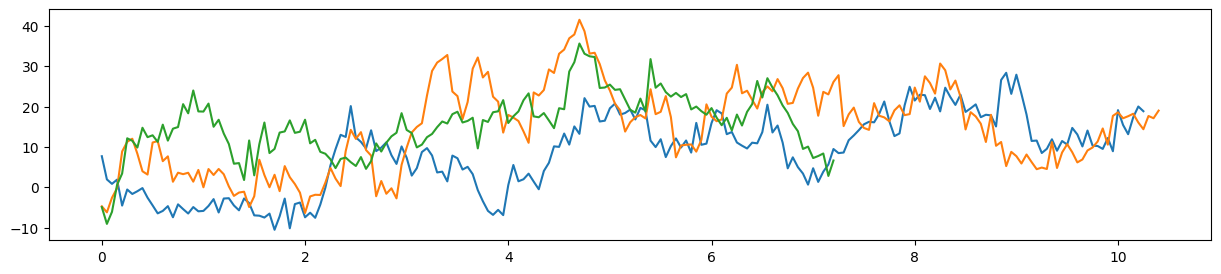

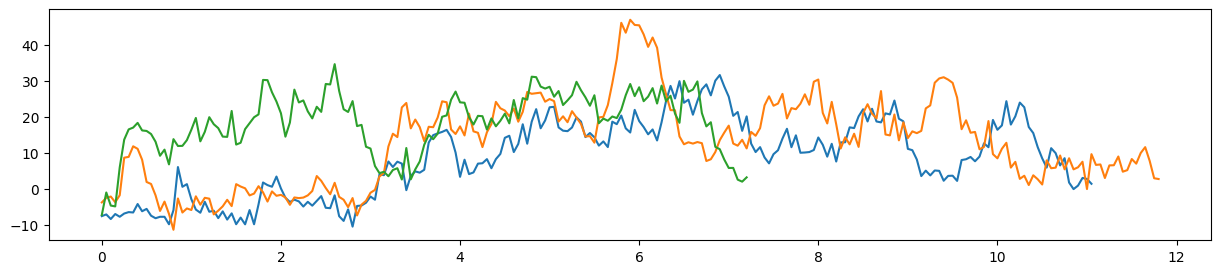

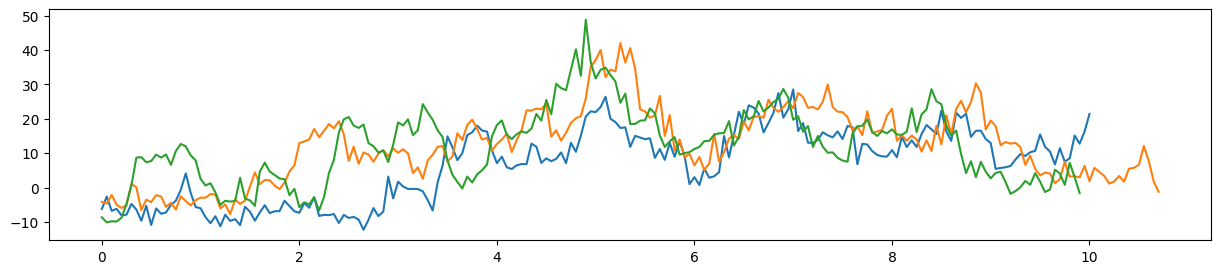

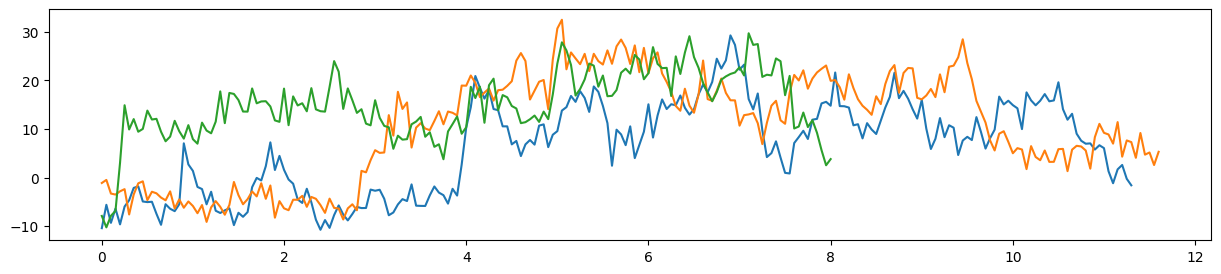

In [17]:
sessions = [
    "ken_20230614_spikes_sorted_SES",
    "ken_20230618_spikes_sorted_SES",
    "ken_20230622_spikes_sorted_SES",
]

for j in range(5):
    fig, ax = plt.subplots(figsize=(15, 3))

    for session in sessions:
        SPIKE_COUNT_PC_DIR = Path(f"data/gbyk/{session}/spike_count/")
        spike_count_pc = ml.data.load_from_memmap(SPIKE_COUNT_PC_DIR)
        pca = PCA(n_components=1)
        spike_count_pcs = pca.fit_transform(spike_count_pc)

        TRIALS_DIR = Path(f"data/gbyk/{session}/trials/")
        trials = list(sorted(TRIALS_DIR.iterdir()))

        with open(trials[j], "rb") as f:
            trial_info = yaml.safe_load(f)
            start = int(trial_info["first_frame_idx"] / 50)
            end = start + int(trial_info["num_frames"] / 50)

            time = np.arange(0, end - start) / 20
            ax.plot(time, spike_count_pcs[start:end])

    plt.show()
    plt.close()

### statistics

In [30]:
sessions = [
    "ken_20230614_spikes_sorted_SES",  # while and before
    "ken_20230618_spikes_sorted_SES",  # before
    "ken_20230622_spikes_sorted_SES",  # while, before and free
    "ken_20230629_spikes_sorted_SES",  # while, before and free
    "ken_20230630_spikes_sorted_SES",  # while
    "ken_20230701_spikes_sorted_SES",  # before
    "ken_20230703_spikes_sorted_SES",  # while
]

for i, session in enumerate(sessions):
    SPIKE_COUNT_DIR = Path(f"data/gbyk/{session}/spike_count/")
    spike_count = ml.data.load_from_memmap(SPIKE_COUNT_DIR)
    print(
        f"{session[4:12]} | neurons: {spike_count.shape[1]}\t| mean: {spike_count.mean():.3f} | zeros frac: {np.count_nonzero(spike_count == 0) / spike_count.size:.3f}"
    )

20230614 | neurons: 396	| mean: 1.627 | zeros frac: 0.335
20230618 | neurons: 390	| mean: 1.697 | zeros frac: 0.321
20230622 | neurons: 378	| mean: 1.732 | zeros frac: 0.316
20230629 | neurons: 375	| mean: 1.694 | zeros frac: 0.324
20230630 | neurons: 379	| mean: 1.724 | zeros frac: 0.326
20230701 | neurons: 383	| mean: 1.721 | zeros frac: 0.323
20230703 | neurons: 383	| mean: 1.663 | zeros frac: 0.335


### variance

x-axis: neurons, y-axis: variance

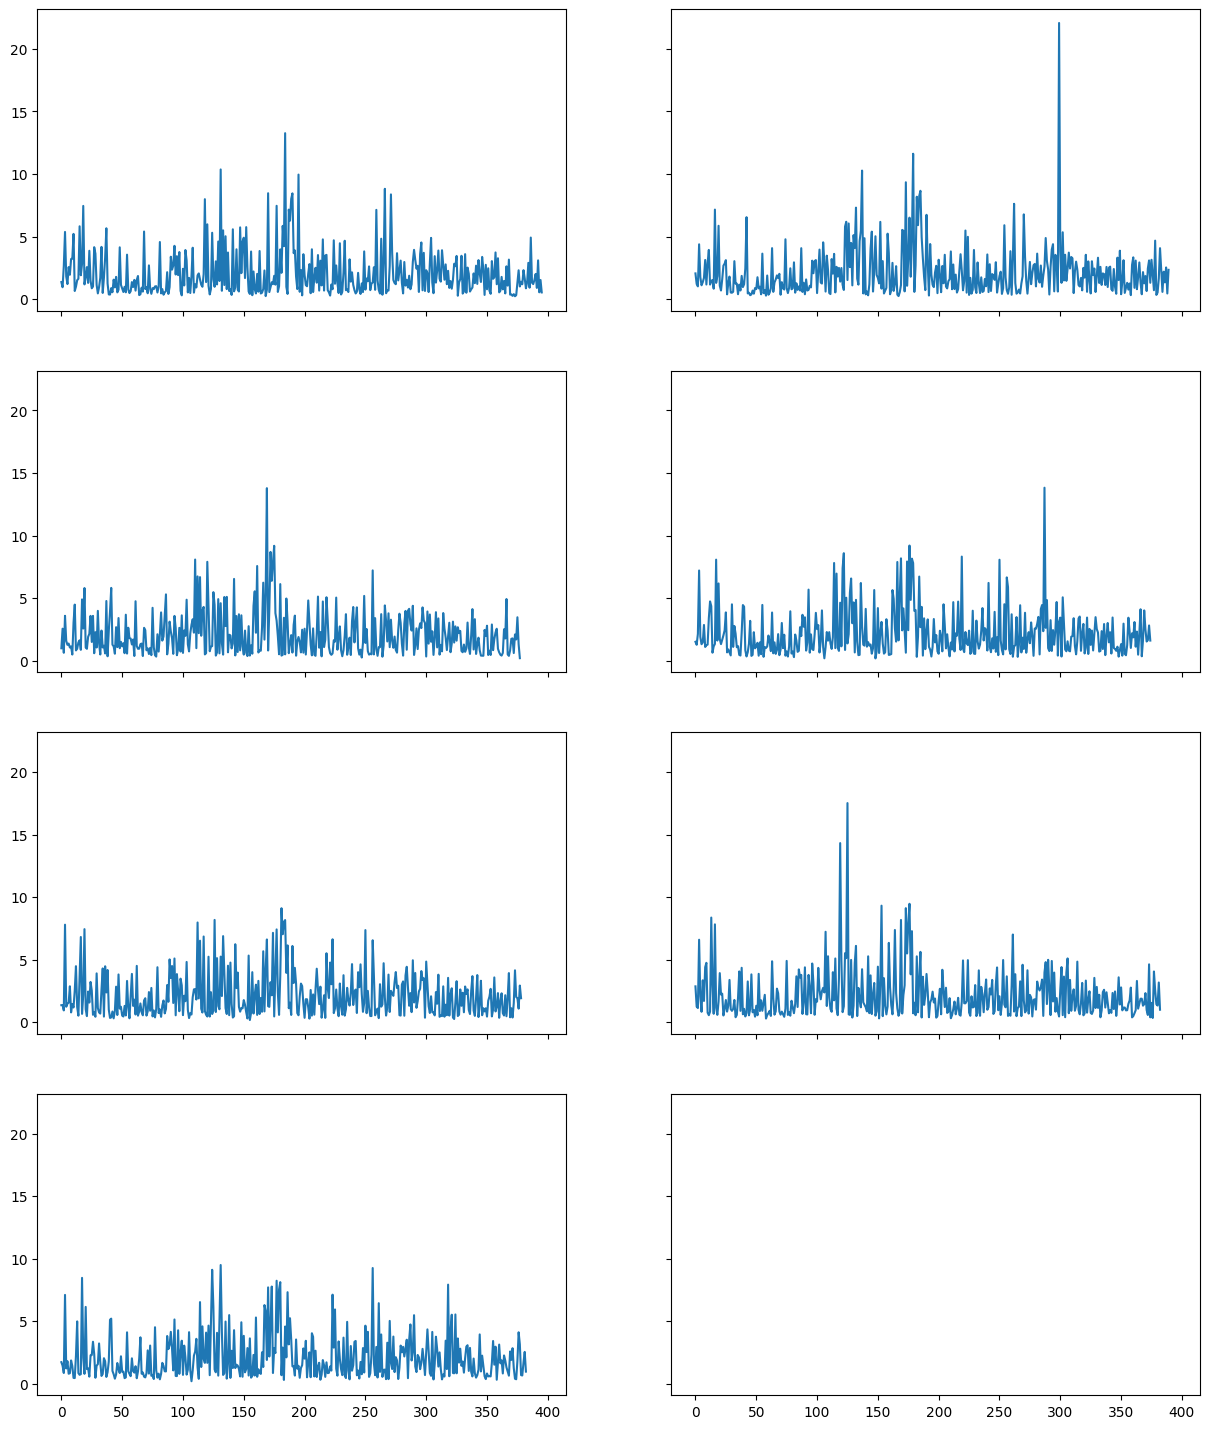

In [39]:
sessions = [
    "ken_20230614_spikes_sorted_SES",  # while and before
    "ken_20230618_spikes_sorted_SES",  # before
    "ken_20230622_spikes_sorted_SES",  # while, before and free
    "ken_20230629_spikes_sorted_SES",  # while, before and free
    "ken_20230630_spikes_sorted_SES",  # while
    "ken_20230701_spikes_sorted_SES",  # before
    "ken_20230703_spikes_sorted_SES",  # while
]

fig, axs = plt.subplots(
    nrows=len(sessions) // 2 + 1,
    ncols=2,
    figsize=(15, 18),
    sharex=True,
    sharey=True,
)

for i, session in enumerate(sessions):
    SPIKE_COUNT_DIR = Path(f"data/gbyk/{session}/spike_count/")
    spike_count = ml.data.load_from_memmap(SPIKE_COUNT_DIR)
    variances = np.var(spike_count, axis=0)
    axs[i // 2, i % 2].plot(variances)

### entropy

x-axis: neurons, y-axis: entropy

In [42]:
def discrete_entropy(x):
    values, counts = np.unique(x, return_counts=True)
    probs = counts / counts.sum()
    return scipy.stats.entropy(probs, base=2)

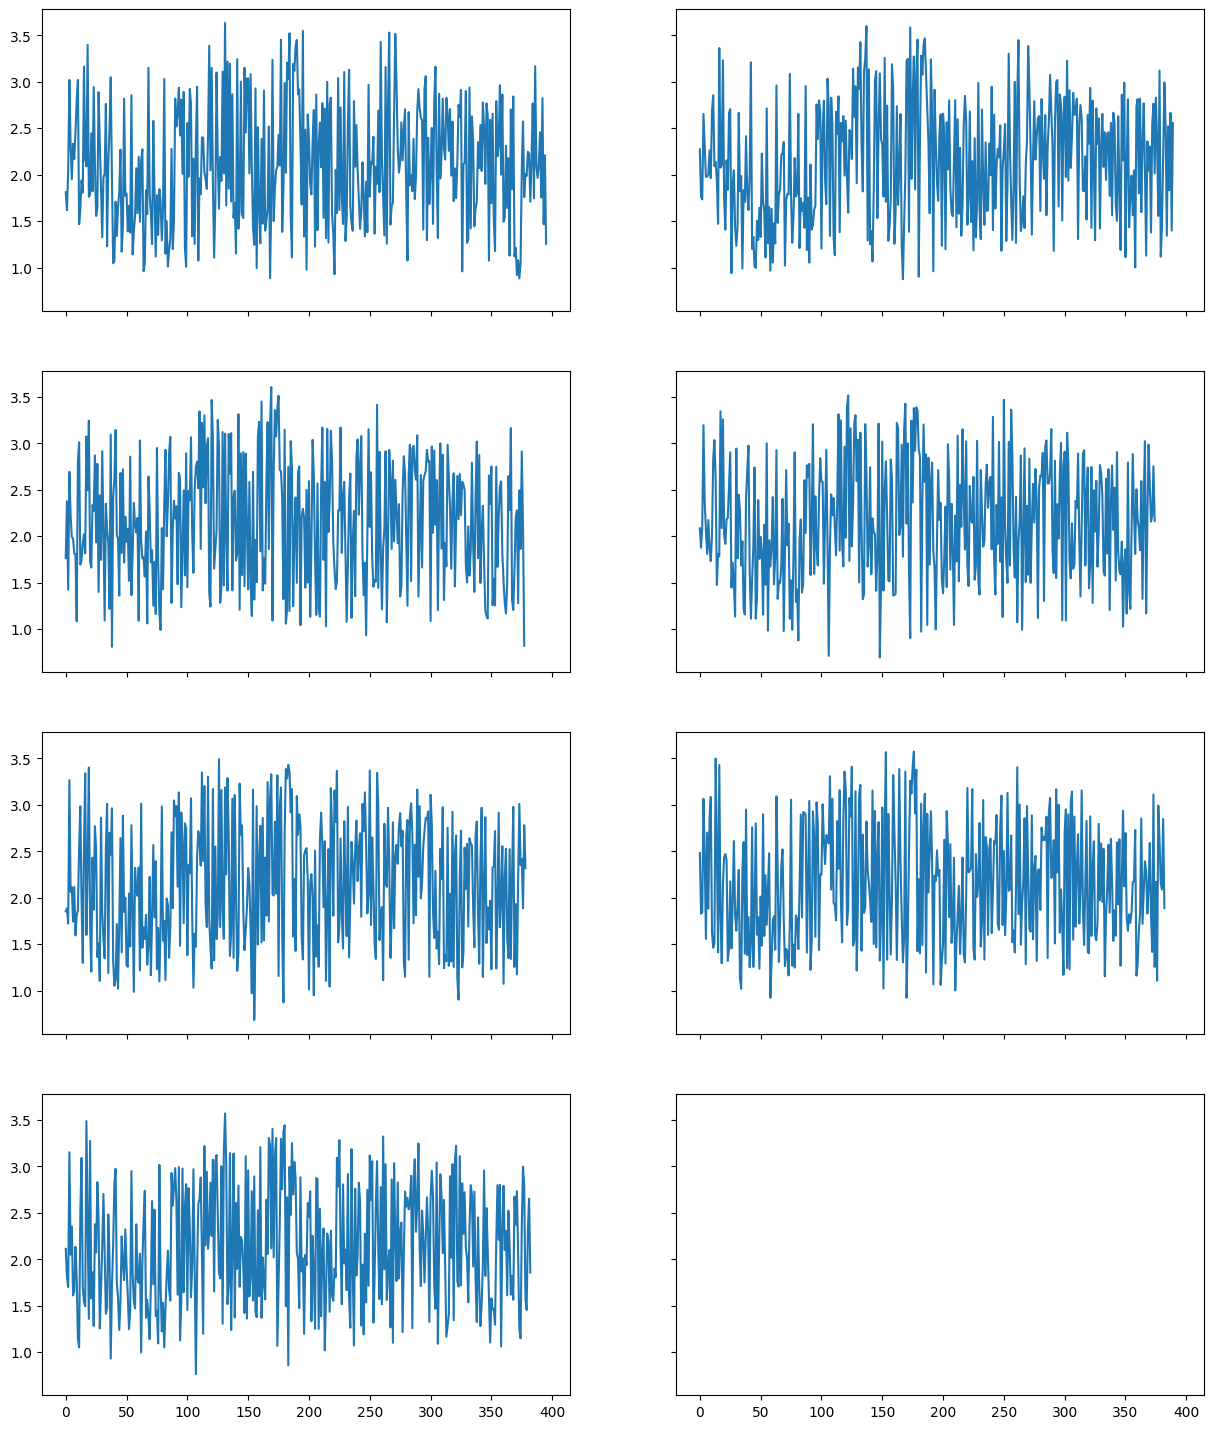

In [43]:
sessions = [
    "ken_20230614_spikes_sorted_SES",  # while and before
    "ken_20230618_spikes_sorted_SES",  # before
    "ken_20230622_spikes_sorted_SES",  # while, before and free
    "ken_20230629_spikes_sorted_SES",  # while, before and free
    "ken_20230630_spikes_sorted_SES",  # while
    "ken_20230701_spikes_sorted_SES",  # before
    "ken_20230703_spikes_sorted_SES",  # while
]

fig, axs = plt.subplots(
    nrows=len(sessions) // 2 + 1,
    ncols=2,
    figsize=(15, 18),
    sharex=True,
    sharey=True,
)

for i, session in enumerate(sessions):
    SPIKE_COUNT_DIR = Path(f"data/gbyk/{session}/spike_count/")
    spike_count = ml.data.load_from_memmap(SPIKE_COUNT_DIR)
    entropies = np.array(
        [
            discrete_entropy(spike_count[:, i])
            for i in range(spike_count.shape[1])
        ]
    )
    axs[i // 2, i % 2].plot(entropies)